<a href="https://colab.research.google.com/github/tsaijieda/drive/blob/main/MLHW4_Prob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Time Series Data Using RNN



## Overview

In this notebook, we show how one can use recurrent neural network to predict time series data.
We will use Google's stock open price as our time series.



In [2]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
def load_data():
    # path to data directory (for testing)
    path_to_data="./"

    ######### LOAD DATA
    # The time series data
    data_file_name = "Google_Stock_Price_Train.csv"
    # The test data
    test_file_name = "Google_Stock_Price_Test.csv"

    # Load the training data
    train_data = pd.read_csv(path_to_data + data_file_name)
    training_set = train_data.iloc[:, 1:2].values  # Assuming the stock prices are in the second column
    L = len(training_set)
    print("Length of training data: ", L)
    # Normalize the data
    sc = MinMaxScaler() # default is 0,1
    # Fitting to training_set, scale training set,
    # transform we'll apply normalizationjust need min and max for normalization
    training_set = sc.fit_transform(training_set)

    # X_train is the input data and y_train is the output data
    X_train = training_set[0:L-1]
    y_train = training_set[1:L]

    # Load the test data
    test_data = pd.read_csv(path_to_data + test_file_name)
    test_set = test_data.iloc[:, 1:2].values  # Assuming the stock prices are in the second column
    test_set = sc.transform(test_set)
    # Convert to PyTorch tensors
    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)
    X_test = torch.FloatTensor(test_set)
    print("Finished loading data")
    return X_train, y_train, X_test

Length of training data:  1258
Finished loading data


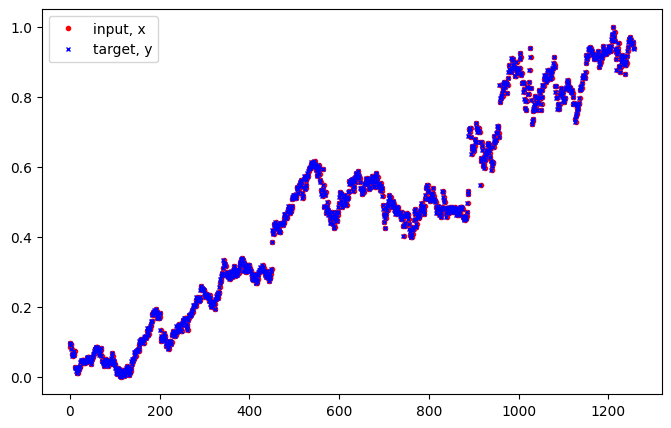

In [5]:
plt.figure(figsize=(8, 5))
# generate evenly spaced data pts
X_train, y_train, X_test=load_data()

# display the data
plt.plot(X_train, "ro", markersize=3,label="input, x")  # x
plt.plot(y_train, "bx", markersize=3, label="target, y")  # y

plt.legend(loc="best")
plt.show()

## Define the RNN

Next, we define an RNN in PyTorch. We'll use `nn.RNN` to create an RNN layer, then we'll add a last, fully-connected layer to get the output size that we want. An RNN takes in a number of parameters:
* **input_size** - the size of the input
* **hidden_dim** - the number of features in the RNN output and in the hidden state
* **n_layers** - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a stacked RNN
* **batch_first** - whether or not the input/output of the RNN will have the batch_size as the first dimension (batch_size, seq_length, hidden_dim)


Take a look at the [RNN documentation](https://pytorch.org/docs/stable/nn.html#rnn) to read more about recurrent layers.

In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)

        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)

        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)

        # get final output
        output = self.fc(r_out)

        return output, hidden

---
## Training the RNN

Next, we'll instantiate an RNN with some specified hyperparameters. Then train it over a series of steps, and see how it performs.

In [7]:
# decide on hyperparameters
input_size = 1
output_size = 1
hidden_dim = 32
n_layers = 1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


### Defining the training function

This function takes in an rnn, a number of steps to train for, and returns a trained rnn. This function is also responsible for displaying the loss and the predictions, every so often.

#### Hidden State

Pay close attention to the hidden state, here:
* Before looping over a batch of training data, the hidden state is initialized
* After a new hidden state is generated by the RNN, we get the latest hidden state, and use that as input to the rnn for the following steps

In [8]:
# train the RNN
def train(rnn, n_steps, print_every):
    loss_list = []
    iteration_list = []
    accuracy_list = []
    # initialize the hidden state
    hidden = None
    # define the training data
    X_train, y_train, X_test = load_data()

    # define the optimizer
    optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    for batch_i, step in enumerate(range(n_steps)):
        # outputs from the rnn
        prediction, hidden = rnn(X_train, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_train)
        loss_list.append(loss.item())
        iteration_list.append(step)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i % print_every == 0:
            print(f"Step:{batch_i} Loss:{loss.item()} ")
            #plt.plot(X_train, "r.")  # input
            #plt.plot(prediction.data.numpy().flatten(), "b.")  # predictions
            #plt.show()

    return rnn

In [9]:
# train the rnn and monitor results
n_steps = 1000
print_every = 20

trained_rnn = train(rnn, n_steps, print_every)

Length of training data:  1258
Finished loading data
Step:0 Loss:0.14139807224273682 
Step:20 Loss:0.05974464863538742 
Step:40 Loss:0.0231938473880291 
Step:60 Loss:0.0027218961622565985 
Step:80 Loss:0.0020982215646654367 
Step:100 Loss:0.0017022046959027648 
Step:120 Loss:0.0016144096152856946 
Step:140 Loss:0.00155640987213701 
Step:160 Loss:0.0015056064585223794 
Step:180 Loss:0.0014588834019377828 
Step:200 Loss:0.001415745704434812 
Step:220 Loss:0.0013759993016719818 
Step:240 Loss:0.001339063048362732 
Step:260 Loss:0.0013045475352555513 
Step:280 Loss:0.0012721269158646464 
Step:300 Loss:0.0012415624223649502 
Step:320 Loss:0.0012126717483624816 
Step:340 Loss:0.0011853099567815661 
Step:360 Loss:0.0011593621456995606 
Step:380 Loss:0.0011347322724759579 
Step:400 Loss:0.0011113383807241917 
Step:420 Loss:0.0010891095735132694 
Step:440 Loss:0.0010679825209081173 
Step:460 Loss:0.0010479016928002238 
Step:480 Loss:0.0010288164485245943 
Step:500 Loss:0.0010106819681823254 
St

## Homework Problem

(a) Test your trained RNN prediction against `X_test`. Show the accuracy.

(b) Replace the simple RNN with LSTM.  You need modify `load_data` to generate windowed time sequence using the following function.


In [10]:
### Take a time series data input_data and a window size tw and return a list of tuples of input/output data points.
### The input data points are the stock prices at a time t, t+1, t+2, ..., t+tw-1, and
### The output data points are the stock prices at time t+tw.


def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i : i + tw]
        train_label = input_data[i + tw : i + tw + 1]
        inout_seq.append((train_seq, train_label))
    return inout_seq


Mean Squared Error on Test Data: 0.04048344865441322


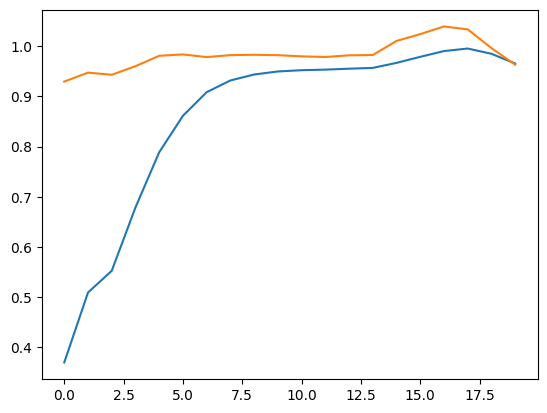

In [13]:
haha, temp = trained_rnn(X_test, None)
mse = mean_squared_error(X_test, haha.detach())
print(f"Mean Squared Error on Test Data: {mse}")
plt.plot(haha.detach())
plt.plot(X_test)

We could see that the first few days have poor performance because first few days doesn't have history to predict the future.

Length of training data: 1258
Finished loading data


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.001271480808543888
Epoch 25 Loss: 0.00033383646903173024
Epoch 50 Loss: 0.00033235102204987114
Epoch 75 Loss: 0.0003279296829022935
Epoch 100 Loss: 0.0003210824126950669
Epoch 125 Loss: 0.00031468238460565765
Finished Training - Final Loss: 0.00030931607927411187


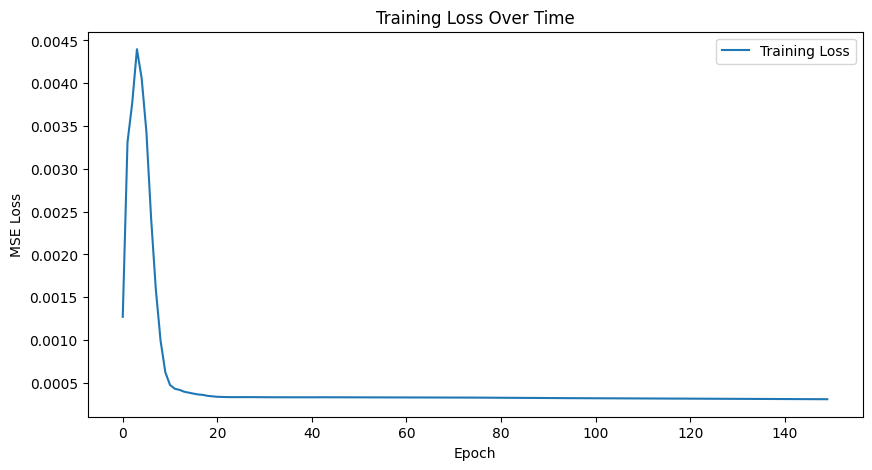

Mean Squared Error on Normalized Test Data: 0.00023775424558957612


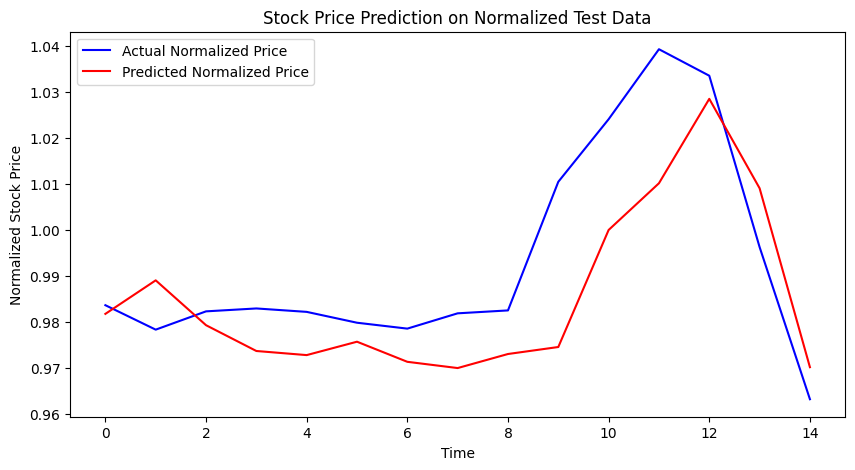

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Define hyperparameters
TIME_WINDOW = 5           # Number of time steps in each input sequence
HIDDEN_LAYER_SIZE = 100     # Number of features in the hidden state of the LSTM
OUTPUT_SIZE = 1             # Number of outputs (1 for single-value predictions)
LEARNING_RATE = 0.001       # Learning rate for the optimizer
EPOCHS = 150                # Number of training epochs
DATA_PATH = "./"            # Path to the directory containing the data files

# Function to create sequences with labels for training
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i : i + tw]
        train_label = input_data[i + tw : i + tw + 1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

# Load and preprocess data
def load_data():
    # File names
    data_file_name = "Google_Stock_Price_Train.csv"
    test_file_name = "Google_Stock_Price_Test.csv"

    # Load the training data
    train_data = pd.read_csv(DATA_PATH + data_file_name)
    training_set = train_data.iloc[:, 1:2].values  # Assuming stock prices are in the second column
    L = len(training_set)
    print("Length of training data:", L)

    # Normalize the data
    sc = MinMaxScaler()  # Default is (0,1)
    training_set = sc.fit_transform(training_set)

    # Use create_inout_sequences to generate windowed sequences
    training_data = torch.FloatTensor(training_set)
    inout_sequences = create_inout_sequences(training_data, TIME_WINDOW)

    # Separate sequences and labels
    X_train = torch.stack([seq for seq, label in inout_sequences])
    y_train = torch.stack([label for seq, label in inout_sequences])

    # Load and scale test data
    test_data = pd.read_csv(DATA_PATH + test_file_name)
    test_set = test_data.iloc[:, 1:2].values  # Assuming stock prices are in the second column
    test_set_scaled = sc.transform(test_set)
    X_test = torch.FloatTensor(test_set_scaled)

    print("Finished loading data")
    return X_train, y_train, X_test, sc

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=HIDDEN_LAYER_SIZE, output_size=OUTPUT_SIZE):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        # Define the output layer
        self.linear = nn.Linear(hidden_layer_size, output_size)

        # Initialize the hidden state
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        # Run LSTM layer
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]  # Return last prediction in sequence

# Training function
def train_model(model, X_train, y_train, epochs=EPOCHS, learning_rate=LEARNING_RATE):
    # Define loss function and optimizer
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Track loss for plotting
    all_losses = []

    # Training loop
    for epoch in range(epochs):
        epoch_loss = 0
        for seq, labels in zip(X_train, y_train):
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))

            # Forward pass
            y_pred = model(seq)

            # Calculate loss
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()

            # Accumulate loss for epoch
            epoch_loss += single_loss.item()

        avg_epoch_loss = epoch_loss / len(X_train)
        all_losses.append(avg_epoch_loss)

        if epoch % 25 == 0:
            print(f'Epoch {epoch} Loss: {avg_epoch_loss}')

    print(f'Finished Training - Final Loss: {avg_epoch_loss}')
    return all_losses

# Function to make predictions on test data
def make_predictions(model, X_test):
    model.eval()  # Set the model to evaluation mode
    predictions = []

    # Ensure we have enough data to create the sequences
    for i in range(len(X_test) - TIME_WINDOW):
        seq = X_test[i:i + TIME_WINDOW]
        with torch.no_grad():
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))
            predictions.append(model(seq).item())

    return predictions

# Main execution
if __name__ == "__main__":
    # Load the data
    X_train, y_train, X_test, sc = load_data()

    # Initialize and train the LSTM model
    model = LSTM()
    loss_history = train_model(model, X_train, y_train)

    # Plot the training loss over time
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()

    # Make predictions on the normalized test set
    predictions = make_predictions(model, X_test)

    # Load actual normalized test data for comparison
    test_data = pd.read_csv(DATA_PATH + "Google_Stock_Price_Test.csv")
    test_set = test_data.iloc[:, 1:2].values
    test_set_scaled = sc.transform(test_set)  # Use normalized data directly
    actual_prices = test_set_scaled[TIME_WINDOW:]  # Adjust for time window offset

    # Calculate MSE in normalized range
    mse = mean_squared_error(actual_prices, predictions)
    print(f"Mean Squared Error on Normalized Test Data: {mse}")

    # Plot predictions vs. actual test data in normalized range
    plt.figure(figsize=(10, 5))
    plt.plot(actual_prices, label='Actual Normalized Price', color='blue')
    plt.plot(predictions, label='Predicted Normalized Price', color='red')
    plt.xlabel('Time')
    plt.ylabel('Normalized Stock Price')
    plt.title('Stock Price Prediction on Normalized Test Data')
    plt.legend()
    plt.show()


- The loss is converging at last, so its a usable model.
- We could see that the stock is shifted by a day or some, this is majorly caused by the poor model. It might only predict the next day by enetering the last day price or something.